In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
#from myFunctions import lcl
#from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager


# read humidity binned values over SST to prepare the composite plot
path_SST_binned = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/'
filename = 'arthus_binned_sst.nc'
arthus_data = xr.open_dataset(path_SST_binned+filename)
mr_data = arthus_data['MR'].values
sst_arr = arthus_data['sst'].values
height = arthus_data['height'].values


In [2]:
# reading radiosonde binned data
radiosonde_data = xr.open_dataset(path_SST_binned+'RS_mean_profiles_binned_sst.nc')
MR_rs = radiosonde_data['MR'].values
binned_sst_rs = radiosonde_data['sst'].values
height_rs = radiosonde_data['height'].values


#defining color palette for subsequent plots
colors_binned_sst = plt.cm.seismic(np.linspace(0, 1, len(binned_sst_rs)))
# plot multipanel with all profiles


In [6]:
binned_sst_rs

array([26.3, 26.6, 26.8, 27.1, 27.3, 27.6])

['SST = 26.3', 'SST = 26.6', 'SST = 26.8', 'SST = 27.1', 'SST = 27.3', 'SST = 27.6']


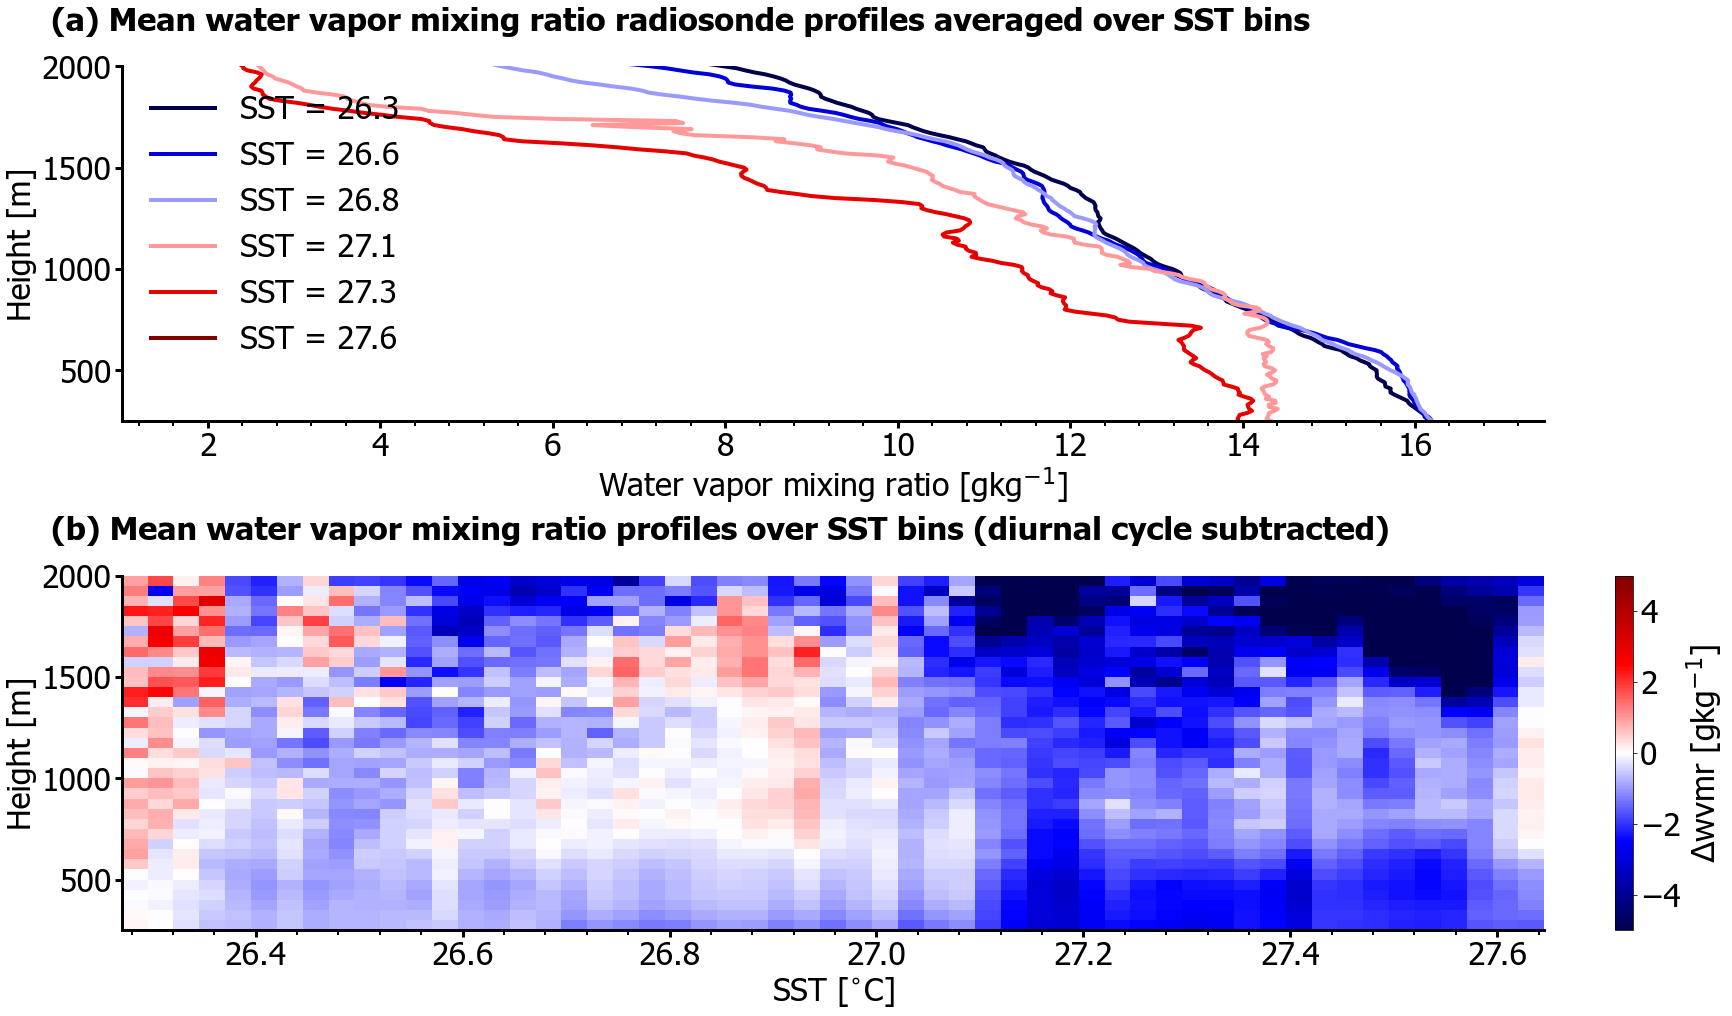

In [8]:

# calculate label marks for bins
sst_bin_label = []
for ind in range(len(binned_sst_rs)-1):
    sst_bin_label.append(round((binned_sst_rs[ind]+binned_sst_rs[ind+1])/2,2))
    


labels =[]
for ind, el in enumerate(binned_sst_rs):
    labels.append('SST = '+str(el))
print(labels)
font = font_manager.FontProperties(family='Tahoma',
                                   weight='light',
                                   style='normal', size=12)


# composite figure variables binned in sst 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'



dict_plot_settings = {
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :15,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']

fig, axs = plt.subplots(2,1, figsize=(24,14), constrained_layout=True)

# setting dates formatter 
#[a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) for a in axs[:].flatten()]
matplotlib.rc('xtick', labelsize=32)  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=32)  # sets dimension of ticks in the plots
grid            = dict_plot_settings['grid']

for ind_sst_bin in range(len(binned_sst_rs)): 
    axs[0].plot(MR_rs[ind_sst_bin,:]*1000., height_rs, color=colors_binned_sst[ind_sst_bin], label=labels[ind_sst_bin], linewidth=4, rasterized=True)
axs[0].legend(frameon=False, fontsize=fontSizeX, loc='upper left')
axs[0].set_xlabel("Water vapor mixing ratio [gkg$^{-1}$]", fontsize=fontSizeX)
axs[0].set_ylabel("Height [m]", fontsize=fontSizeY)
axs[0].set_xlim(1,17.5)

mesh = axs[1].pcolormesh(sst_arr, height, mr_data.T, cmap='seismic', vmin=-5, vmax=5, )
cbar = fig.colorbar(mesh, ax=axs[1])
cbar.set_label(label='$\Delta$wvmr [gkg$^{-1}$]',  size=fontSizeX)
axs[1].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[1].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)

for ax, l in zip(axs[:].flatten(), ['(a) Mean water vapor mixing ratio radiosonde profiles averaged over SST bins  ',  '(b) Mean water vapor mixing ratio profiles over SST bins (diurnal cycle subtracted) ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=32)
    ax.set_ylim(250.,2000.)

fig.savefig(path_out_plots+'figure_wvmr.png', format='png')